## Assignment 5 – SeleneX Mini-Prototype: Ovarian Ultrasound + Biomarker Diagnostic Pipeline 

## 1. Importing Libraries

In [1]:
import os

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_recall_curve, roc_auc_score,
                             roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import (Model, Input, applications, layers, models)
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-08-19 15:14:20.989896: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755616461.185194      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755616461.245338      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df=pd.read_csv('/kaggle/input/selenex-assignment5/train_split.csv')
val_df=pd.read_csv('/kaggle/input/selenex-assignment5/val_split.csv')
test_df=pd.read_csv('/kaggle/input/selenex-assignment5/test_split.csv')

In [3]:
# Paths
image_dir = "/kaggle/input/mmotu-ovarian-ultrasound-images-dataset/MMOTU/OTU_2d/images"

## 2. Image Preprocessing

In [4]:
def load_and_preprocess_image(img_id, image_dir):
    img_path = os.path.join(image_dir, f"{img_id}.JPG")
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Image {img_id}.JPG not found in {image_dir}")
    # Convert grayscale to RGB (if needed)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # Resize and normalize
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    return img

In [5]:
# Initialize storage for each split
X_images_train = []
X_images_val = []
X_images_test = []

# Load and preprocess training images
for img_id in tqdm(train_df["Image_ID"], desc="Loading training images"):
    try:
        img = load_and_preprocess_image(img_id, image_dir)
        X_images_train.append(img)
    except FileNotFoundError as e:
        print(e)
        continue

# Load and preprocess validation images
for img_id in tqdm(val_df["Image_ID"], desc="Loading validation images"):
    try:
        img = load_and_preprocess_image(img_id, image_dir)
        X_images_val.append(img)
    except FileNotFoundError as e:
        print(e)
        continue

# Load and preprocess test images
for img_id in tqdm(test_df["Image_ID"], desc="Loading test images"):
    try:
        img = load_and_preprocess_image(img_id, image_dir)
        X_images_test.append(img)
    except FileNotFoundError as e:
        print(e)
        continue

Loading test images: 100%|██████████| 150/150 [00:01<00:00, 79.35it/s]


In [6]:
# Convert lists to NumPy arrays
X_images_train = np.array(X_images_train)
X_images_val = np.array(X_images_val)
X_images_test = np.array(X_images_test)

In [7]:
tab_features = ["Age", "CA125", "BRCA_Status"]

In [8]:
X_train = train_df[tab_features].astype(np.float32).values
y_train = train_df["Label"].astype(int).values

X_val   = val_df[tab_features].astype(np.float32).values
y_val   = val_df["Label"].astype(int).values

X_test  = test_df[tab_features].astype(np.float32).values
y_test  = test_df["Label"].astype(int).values

## 3. Image-only Model

In [9]:
# Image-only CNN
from tensorflow.keras import Input, Model, layers

def build_image_model(input_shape=(224,224,3)):
    img_input = Input(shape=input_shape)
    x = layers.Conv2D(32, (3,3), activation='relu', name="conv1")(img_input)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu', name="conv2")(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(128, (3,3), activation='relu', name="conv3")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs=img_input, outputs=output)

img_model = build_image_model()

img_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

I0000 00:00:1755616486.376838      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 4. Tabular-only Model

In [10]:
def build_tabular_model(input_dim=3):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

tab_model = build_tabular_model()
tab_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


## 5. Fused Multimodal Model

In [11]:

def build_fused_model(img_shape=(224,224,3), tab_dim=3):
    # Image encoder
    img_input = Input(shape=img_shape)
    x = layers.Conv2D(32, (3,3), activation='relu')(img_input)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.Conv2D(64, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D(2,2)(x)
    x = layers.GlobalAveragePooling2D()(x)
    img_vec = layers.Dense(64, activation='relu')(x)

    # Tabular encoder
    tab_input = Input(shape=(tab_dim,))
    y = layers.Dense(32, activation='relu')(tab_input)
    tab_vec = layers.Dense(16, activation='relu')(y)

    # Concatenate
    fused = layers.concatenate([img_vec, tab_vec])
    fused = layers.Dense(64, activation='relu')(fused)
    output = layers.Dense(1, activation='sigmoid')(fused)

    model = Model(inputs=[img_input, tab_input], outputs=output)
    return model

fused_model = build_fused_model()
fused_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [12]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)

# Train image-only
history_img = img_model.fit(
    X_images_train, y_train,
    validation_data=(X_images_val, y_val),
    epochs=20, batch_size=32,
    callbacks=[callback],
    class_weight=class_weights

)

# Train tabular-only
history_tab = tab_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=32,
    callbacks=[callback],
    class_weight=class_weights

)



fused_model.fit(
    [X_images_train, X_train], y_train,
    validation_data=([X_images_val, X_val], y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights
)


Epoch 1/20


I0000 00:00:1755616491.670166      98 service.cc:148] XLA service 0x7e77bc003e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755616491.670962      98 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755616492.006440      98 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3825 - loss: 0.7150

I0000 00:00:1755616495.476306      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.3712 - loss: 0.7026 - val_accuracy: 0.6600 - val_loss: 0.6913
Epoch 2/20
 5/22 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6407 - loss: 0.7058

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6623 - loss: 0.6944 - val_accuracy: 0.6600 - val_loss: 0.6920
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.4696 - loss: 0.7043 - val_accuracy: 0.6067 - val_loss: 0.6930
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6456 - loss: 0.6942 - val_accuracy: 0.6600 - val_loss: 0.6912
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6850 - loss: 0.6824 - val_accuracy: 0.6600 - val_loss: 0.6910
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6861 - loss: 0.6817 - val_accuracy: 0.6600 - val_loss: 0.6916
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5734 - loss: 0.6928 - val_accuracy: 0.3400 - val_loss: 0.6967
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4171 - loss: 0.6892 - val_accuracy: 0.6600 - val_loss: 0.6923
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6532 - loss: 0.6882 - val_accuracy: 0.6467 - val_loss: 0.

## 6. Evaluation on Test Set

In [13]:
def evaluate_model(model, X, y, is_fused=False, tab_input=None):
    if is_fused:
        y_pred_prob = model.predict([X, tab_input]).ravel()
    else:
        y_pred_prob = model.predict(X).ravel()
    
    y_pred = (y_pred_prob > 0.5).astype(int)

    print(classification_report(y, y_pred))
    print("ROC-AUC:", roc_auc_score(y, y_pred_prob))

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y, y_pred_prob):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
              precision    recall  f1-score   support

           0       0.78      0.36      0.49       100
           1       0.38      0.80      0.52        50

    accuracy                           0.51       150
   macro avg       0.58      0.58      0.51       150
weighted avg       0.65      0.51      0.50       150

ROC-AUC: 0.6174


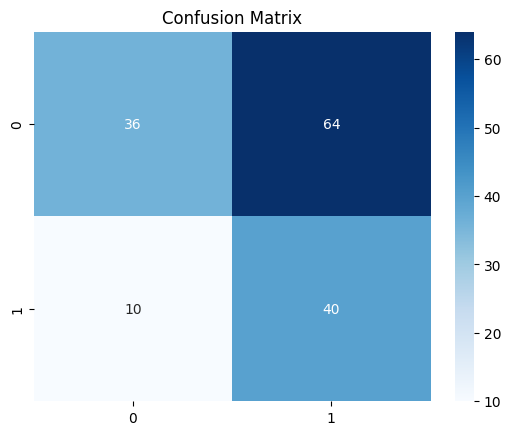

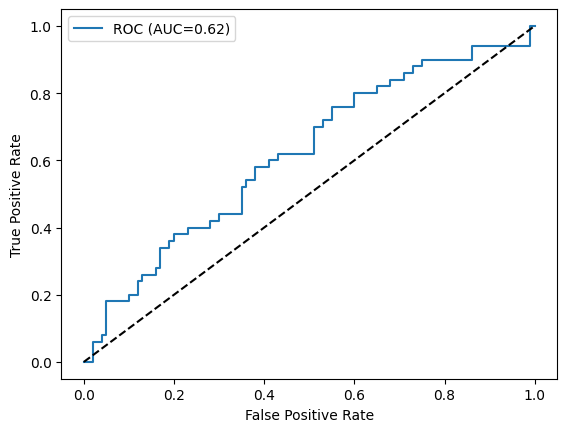

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

ROC-AUC: 1.0


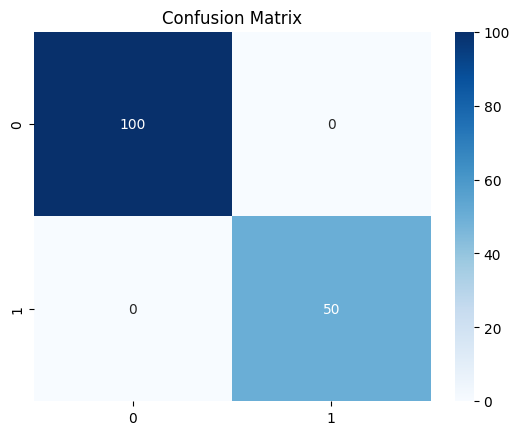

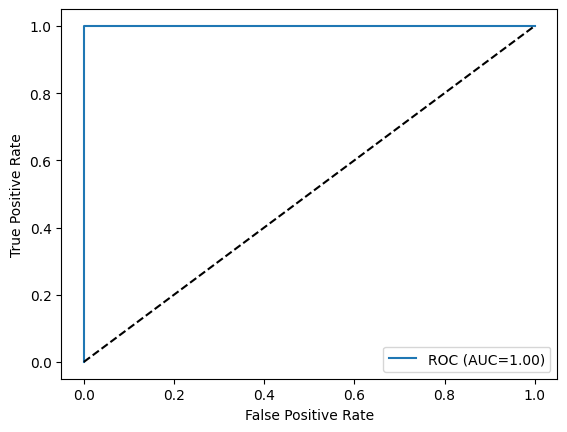

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00        50

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

ROC-AUC: 1.0


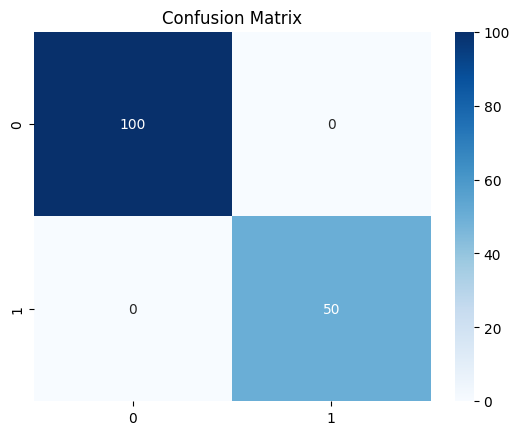

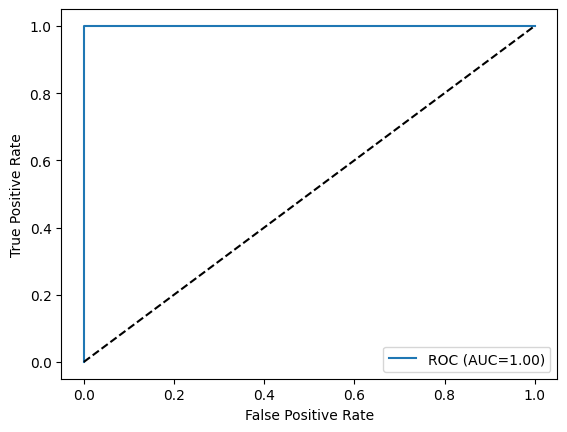

In [14]:
# Evaluate all three
evaluate_model(img_model, X_images_test, y_test)
evaluate_model(tab_model, X_test, y_test)
evaluate_model(fused_model, X_images_test, y_test, is_fused=True, tab_input=X_test)


In [15]:
img_model.save("/kaggle/working/image_model.h5")
tab_model.save("/kaggle/working/tabular_model.h5")
fused_model.save("/kaggle/working/fused_model.h5")

In [16]:
# warm up so keras "calls" the model
_ = img_model.predict(X_images_test[:1])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


## 7. Grad-CAM helper

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Using target layer: conv3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


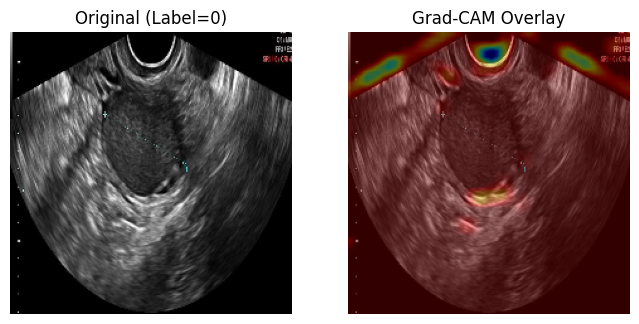

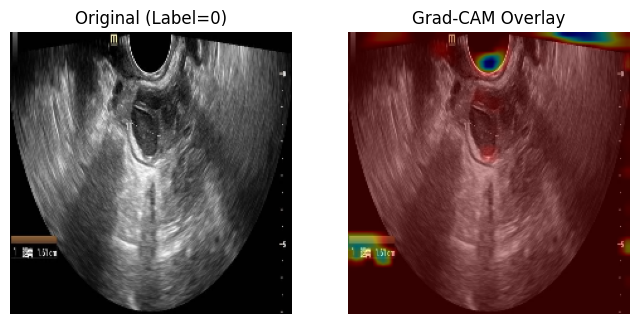

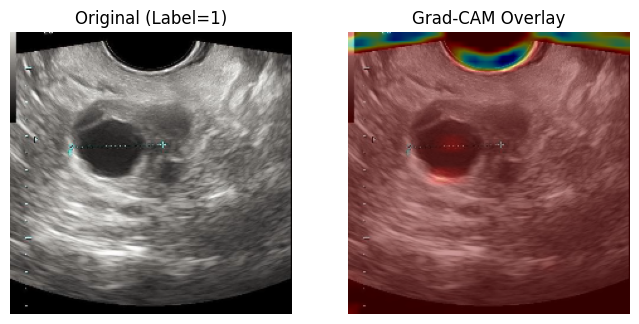

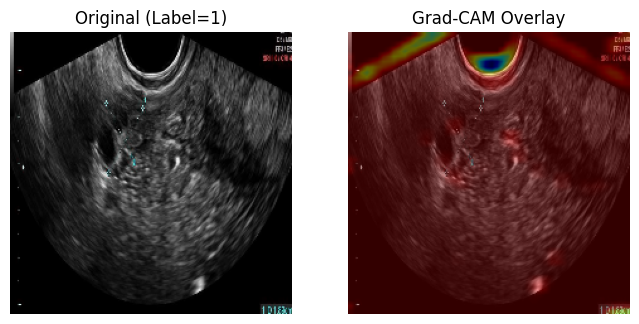

In [17]:
# --- Grad-CAM helper ---
def make_gradcam_heatmap(img_array, model, target_layer=None, pred_index=None):
    if target_layer is None:
        # auto-pick last Conv2D layer
        conv_layers = [l for l in model.layers if isinstance(l, tf.keras.layers.Conv2D)]
        target_layer = conv_layers[-1]

    grad_model = tf.keras.models.Model(
        [model.input],
        [target_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4, cmap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cmap)
    superimposed_img = cv2.addWeighted(heatmap, alpha, img, 1-alpha, 0)
    return superimposed_img

# --- Warm up model (so it's "called") ---
_ = img_model.predict(X_images_test[:1])

# pick the last conv layer explicitly
target_layer = [l for l in img_model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]
print("Using target layer:", target_layer.name)

# --- Select 2 benign & 2 malignant (adjust indices as needed) ---
benign_idx = [i for i, y in enumerate(y_test) if y == 0][:2]
malignant_idx = [i for i, y in enumerate(y_test) if y == 1][:2]
sample_indices = benign_idx + malignant_idx

for idx in sample_indices:
    img = X_images_test[idx:idx+1]
    label = y_test[idx]

    heatmap = make_gradcam_heatmap(img, img_model, target_layer=target_layer)
    disp_img = (img[0] * 255).astype(np.uint8)
    superimposed_img = overlay_gradcam(disp_img, heatmap)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(disp_img)
    plt.title(f"Original (Label={label})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Overlay")
    plt.axis("off")
    plt.show()


## 9. Other approach for image model

In [19]:
# ===========================================
# SETTINGS
# ===========================================
IMAGE_SIZE = 224
RESIZE_TO = 256  
BATCH_SIZE = 16   
EPOCHS = 150
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(SEED)
tf.random.set_seed(SEED)


def clean_image_ids(df):
    df = df.copy()
    # Convert to string and remove float artifacts
    df['Image_ID'] = df['Image_ID'].apply(
        lambda x: str(int(x)) if isinstance(x, float) else str(x)
    )
    # Remove any potential trailing .0
    df['Image_ID'] = df['Image_ID'].str.replace(r'\.0$', '', regex=True)
    return df.dropna(subset=['Image_ID'])

train_df = clean_image_ids(train_df)
val_df = clean_image_ids(val_df)
test_df = clean_image_ids(test_df)

# Ensure labels are 0/1 ints
train_df['Label'] = train_df['Label'].astype(int)
val_df['Label'] = val_df['Label'].astype(int)
test_df['Label'] = test_df['Label'].astype(int)


aug_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.3),
    A.RandomBrightnessContrast(p=0.4),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.1),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.1),
    A.RandomGamma(gamma_limit=(80, 120), p=0.2),
    A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.15),
])

def load_and_preprocess_image(img_id, image_dir, augment=False):
    img_path = os.path.join(image_dir, f"{img_id}.JPG")
    
    img = None
    # Try primary path then other extensions
    for ext in ['', '.jpg', '.JPG', '.png', '.jpeg', '.JPEG']:
        attempt = os.path.join(image_dir, f"{img_id}{ext}" if ext else f"{img_id}.JPG")
        if os.path.exists(attempt):
            img = cv2.imread(attempt, cv2.IMREAD_COLOR)
            if img is not None:
                break

    if img is None:
        # try case-insensitive glob fallback
        for root, dirs, files in os.walk(image_dir):
            for f in files:
                name, ext = os.path.splitext(f)
                if name == img_id:
                    img = cv2.imread(os.path.join(root, f), cv2.IMREAD_COLOR)
                    break
            if img is not None:
                break

    if img is None:
        raise FileNotFoundError(f"Image {img_id} not found in {image_dir}")

    # Channel management
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = img[:, :, :3]

    # Smart resizing with padding (keep aspect ratio)
    h, w = img.shape[:2]
    scale = RESIZE_TO / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Pad to square RESIZE_TO x RESIZE_TO
    pad_top = (RESIZE_TO - new_h) // 2
    pad_bottom = RESIZE_TO - new_h - pad_top
    pad_left = (RESIZE_TO - new_w) // 2
    pad_right = RESIZE_TO - new_w - pad_left
    img = cv2.copyMakeBorder(img, pad_top, pad_bottom, pad_left, pad_right,
                             cv2.BORDER_CONSTANT, value=0)

    # If requested, apply albumentations (helpful when preparing small cache)
    if augment:
        img = aug_pipeline(image=img)['image']

    # Center crop to IMAGE_SIZE for validation/test, for training we'll use tf.data random crop
    start_y = (RESIZE_TO - IMAGE_SIZE) // 2
    start_x = (RESIZE_TO - IMAGE_SIZE) // 2
    img = img[start_y:start_y+IMAGE_SIZE, start_x:start_x+IMAGE_SIZE]

    # Convert to float32 [0,1]
    img = img.astype(np.float32) / 255.0

    return img

# ===========================================
def load_dataset(df, image_dir, augment=False, max_samples=None):
    images = []
    valid_rows = []
    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Loading {'TRAIN' if augment else 'VAL/TEST'}"):
        if max_samples and len(images) >= max_samples:
            break
        img_id = row['Image_ID']
        try:
            img = load_and_preprocess_image(img_id, image_dir, augment=augment and False) # we do not apply alb here to keep augmentation inside tf.data
            images.append(img)
            valid_rows.append(row)
        except Exception as e:
            print(f"Skipping {img_id}: {str(e)}")
    if len(images) == 0:
        return np.array([]), pd.DataFrame(valid_rows)
    return np.stack(images, axis=0), pd.DataFrame(valid_rows)

# Load datasets with filtering (you can set max_samples for quick debugging)
X_images_train, train_df = load_dataset(train_df, image_dir, augment=True)
X_images_val, val_df = load_dataset(val_df, image_dir)
X_images_test, test_df = load_dataset(test_df, image_dir)

# Prepare labels from filtered DataFrames
y_train = train_df["Label"].astype(np.float32).values
y_val = val_df["Label"].astype(np.float32).values
y_test = test_df["Label"].astype(np.float32).values

print("Train/Val/Test shapes:", X_images_train.shape, X_images_val.shape, X_images_test.shape)
print("Class distribution (train):", np.bincount(y_train.astype(int)))

# ===========================================
def random_augment(image):
    # image: float32 [0,1], shape (H,W,3)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # Random rotation multiples of 90 degrees
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    # Random brightness/contrast
    image = tf.image.random_brightness(image, 0.15)
    image = tf.image.random_contrast(image, 0.85, 1.15)
    # Random crop from RESIZE_TO->IMAGE_SIZE (if images already IMAGE_SIZE, this is safe)
    # Add random jitter pad
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    image = tf.image.random_crop(image, size=[IMAGE_SIZE, IMAGE_SIZE, 3])
    # Add small Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02)
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image

def center_crop(image):
    image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
    start = (RESIZE_TO - IMAGE_SIZE) // 2
    image = image[start:start+IMAGE_SIZE, start:start+IMAGE_SIZE, :]
    return image

# EfficientNet preprocess (applies scaling appropriate for chosen model)
def preprocess_for_model(image):
    # expects image in [0,1], convert to model expected range using EfficientNet preprocessing
    image = applications.efficientnet.preprocess_input(image * 255.0)
    return image

def make_dataset(images, labels, training=False, batch_size=BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    if training:
        ds = ds.shuffle(2048, seed=SEED)
        ds = ds.repeat()
        ds = ds.map(lambda x,y: (random_augment(x), y), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x,y: (center_crop(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x,y: (preprocess_for_model(x), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

# MixUp generator wrapper to apply MixUp on batched dataset
def mixup_batch(images, labels, alpha=0.2):
    # images: [B, H, W, C], labels: [B]
    lam = np.random.beta(alpha, alpha)
    batch_size = images.shape[0]
    index = np.random.permutation(batch_size)
    mixed_images = lam * images + (1 - lam) * images[index]
    labels = labels.astype(np.float32)
    mixed_labels = lam * labels + (1 - lam) * labels[index]
    return mixed_images, mixed_labels

# Create training and validation tf.data (we'll use generator to apply MixUp each epoch)
train_ds = make_dataset(X_images_train, y_train, training=True)
val_ds = make_dataset(X_images_val, y_val, training=False)

def binary_focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # Clip to avoid numerical instability
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return loss_fn


def create_model(dropout_rate=0.5, l2_reg=1e-4):
    try:
        base_model = applications.EfficientNetV2S(
            include_top=False,
            weights='imagenet',
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
            pooling='avg'
        )
    except Exception as e:
        # If imagenet weights aren't available (offline), fall back to random init
        print("Could not load imagenet weights:", e)
        base_model = applications.EfficientNetV2S(
            include_top=False,
            weights=None,
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
            pooling='avg'
        )

    # Gradual unfreezing strategy (start with most frozen then unfreeze later)
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True

    x = base_model.output
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=predictions)

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

    model.compile(
        optimizer=optimizer,
        loss=binary_focal_loss(alpha=0.25, gamma=2.0),
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')  # ROC AUC
        ]
    )
    return model

model = create_model()

if len(np.unique(y_train)) == 2:
    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: cw[0], 1: cw[1]}
else:
    class_weights = None

# We removed EarlyStopping per user request; keep ReduceLROnPlateau if desired
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_auc', mode='max')
]

# Steps per epoch (accounting for repeated dataset)
train_steps = max(1, len(X_images_train) // BATCH_SIZE)
val_steps = max(1, len(X_images_val) // BATCH_SIZE)

# Helper functions to safely get/set optimizer learning rate (works for .learning_rate or .lr)
def get_optimizer_lr(optimizer):
    lr_attr = getattr(optimizer, 'learning_rate', None)
    if lr_attr is None:
        lr_attr = getattr(optimizer, 'lr', None)
    if lr_attr is None:
        raise AttributeError("Optimizer has no attribute 'learning_rate' or 'lr'")
    try:
        return float(tf.keras.backend.get_value(lr_attr))
    except Exception:
        # Fallback: try converting to float
        return float(lr_attr)

def set_optimizer_lr(optimizer, new_lr):
    lr_attr = getattr(optimizer, 'learning_rate', None)
    if lr_attr is None:
        lr_attr = getattr(optimizer, 'lr', None)
    if lr_attr is None:
        raise AttributeError("Optimizer has no attribute 'learning_rate' or 'lr'")
    try:
        tf.keras.backend.set_value(lr_attr, new_lr)
    except Exception as e:
        # If we cannot set (e.g., schedule), print warning
        print("Warning: could not set optimizer lr directly:", e)

# Custom training loop wrapper to apply MixUp on each batch during training
def train_with_mixup_no_earlystop(model, train_ds, val_ds, epochs=EPOCHS, steps_per_epoch=train_steps, validation_steps=val_steps):
    # tf.data yields batches of preprocessed images (EfficientNet preprocess applied)
    # We'll convert to numpy, apply mixup, then call model.train_on_batch to keep simplicity and avoid graph hacking.
    best_val_auc = -np.inf
    lr_plateau_wait = 0
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        # Training
        train_iter = iter(train_ds)
        prog = tqdm(range(steps_per_epoch), desc="Train batches")
        train_losses = []
        for _ in prog:
            batch_images, batch_labels = next(train_iter)
            batch_images = batch_images.numpy()
            batch_labels = batch_labels.numpy()
            # Apply MixUp with probability
            if np.random.rand() < 0.7:
                batch_images, batch_labels = mixup_batch(batch_images, batch_labels, alpha=0.2)
            loss, acc, prec, rec, auc = model.train_on_batch(batch_images, batch_labels)
            train_losses.append(loss)
            prog.set_postfix(loss=np.mean(train_losses), auc=auc)
        # Validation evaluation
        val_preds = []
        val_trues = []
        val_iter = iter(val_ds)
        for _ in range(validation_steps):
            imgs, lbls = next(val_iter)
            preds = model.predict_on_batch(imgs)
            val_preds.append(preds.ravel())
            val_trues.append(lbls.numpy().ravel())
        val_preds = np.concatenate(val_preds)
        val_trues = np.concatenate(val_trues)
        # Compute metrics
        try:
            val_auc = roc_auc_score(val_trues, val_preds)
        except:
            val_auc = 0.0
        # Threshold tuning: choose threshold maximizing F1 on validation
        precision, recall, thresholds = precision_recall_curve(val_trues, val_preds)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
        if len(f1_scores) > 0:
            best_idx = np.nanargmax(f1_scores)
            best_thresh = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
            best_f1 = f1_scores[best_idx]
        else:
            best_thresh = 0.5
            best_f1 = 0.0

        print(f"Val AUC: {val_auc:.4f} | Val best F1: {best_f1:.4f} @ thresh {best_thresh:.3f}")

        # Save best model if improved
        if val_auc > best_val_auc + 1e-5:
            best_val_auc = val_auc
            # Save best model
            model.save('best_model.h5')
            lr_plateau_wait = 0
        else:
            # Increase LR plateau patience counter
            lr_plateau_wait += 1

        # Reduce LR logic (no early stopping)
        if lr_plateau_wait >= 8:
            try:
                old_lr = get_optimizer_lr(model.optimizer)
                new_lr = max(1e-7, old_lr * 0.2)
                set_optimizer_lr(model.optimizer, new_lr)
                print(f"ReduceLROnPlateau: {old_lr:.6e} -> {new_lr:.6e}")
            except Exception as e:
                print("Could not reduce LR automatically:", e)
            lr_plateau_wait = 0

    # restore best model
    model = tf.keras.models.load_model('best_model.h5', compile=False)
    # recompile with same loss/metrics
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=binary_focal_loss(alpha=0.25, gamma=2.0),
        metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
    )
    # Return best threshold from last epoch's validation tuning
    return model, best_thresh

# Train (no early stopping)
model, best_threshold = train_with_mixup_no_earlystop(model, train_ds, val_ds, epochs=EPOCHS, steps_per_epoch=train_steps, validation_steps=val_steps)


def tta_predictions(model, images, n_iter=6):
    tta_preds = []
    for i in range(n_iter):
        batch = []
        for img in images:
            # img is in [0,1], apply different transforms: flips, rot90, small brightness
            aug = img.copy()
            if i % 2 == 0:
                aug = np.fliplr(aug)
            if i % 3 == 0:
                aug = np.flipud(aug)
            # small rotations
            if i % 4 == 0:
                aug = np.rot90(aug, k=1)
            # random brightness jitter
            aug = np.clip(aug + (i-3) * 0.01, 0.0, 1.0)
            # center crop to IMAGE_SIZE already done in loading
            aug = applications.efficientnet.preprocess_input((aug * 255.0).astype(np.float32))
            batch.append(aug)
        batch = np.stack(batch, axis=0)
        preds = model.predict(batch, verbose=0).ravel()
        tta_preds.append(preds)
    tta_preds = np.mean(tta_preds, axis=0)
    return tta_preds

print("\nEvaluating with Test-Time Augmentation:")
y_pred_tta = tta_predictions(model, X_images_test, n_iter=6)
y_pred_classes = (y_pred_tta > best_threshold).astype(int)

# Classification report
print("\nEnhanced Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Benign', 'Malignant']))

# Extra metrics
print("ROC AUC (test):", roc_auc_score(y_test, y_pred_tta))
print("Best validation threshold used:", best_threshold)


/tmp/ipykernel_36/3510138611.py:41: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.1),
/tmp/ipykernel_36/3510138611.py:43: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.15),
Loading VAL/TEST: 100%|██████████| 150/150 [00:01<00:00, 134.84it/s]


Train/Val/Test shapes: (700, 224, 224, 3) (150, 224, 224, 3) (150, 224, 224, 3)
Class distribution (train): [465 235]
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Epoch 1/150


Train batches:   0%|          | 0/43 [00:00<?, ?it/s]E0000 00:00:1755616657.715216      36 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755616657.901983      36 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755616658.297394      36 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755616658.493846      36 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755616659.085195      36 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execut

Val AUC: 0.5536 | Val best F1: 0.5202 @ thresh 0.436

Epoch 2/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.43it/s, auc=0.4993728, loss=0.414] 


Val AUC: 0.5716 | Val best F1: 0.5349 @ thresh 0.385

Epoch 3/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.5051445, loss=0.389] 


Val AUC: 0.6238 | Val best F1: 0.5354 @ thresh 0.422

Epoch 4/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.43it/s, auc=0.51759017, loss=0.37] 


Val AUC: 0.6649 | Val best F1: 0.5674 @ thresh 0.422

Epoch 5/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.46it/s, auc=0.5312355, loss=0.351] 


Val AUC: 0.6829 | Val best F1: 0.5645 @ thresh 0.410

Epoch 6/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, auc=0.54111624, loss=0.335]


Val AUC: 0.6954 | Val best F1: 0.5772 @ thresh 0.359

Epoch 7/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.54533255, loss=0.327]


Val AUC: 0.6868 | Val best F1: 0.5793 @ thresh 0.291

Epoch 8/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.59it/s, auc=0.54951453, loss=0.319]


Val AUC: 0.6451 | Val best F1: 0.5455 @ thresh 0.182

Epoch 9/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.44it/s, auc=0.5511104, loss=0.311] 


Val AUC: 0.6299 | Val best F1: 0.5414 @ thresh 0.188

Epoch 10/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.5552038, loss=0.303] 


Val AUC: 0.6550 | Val best F1: 0.5556 @ thresh 0.248

Epoch 11/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, auc=0.55997545, loss=0.297]


Val AUC: 0.6434 | Val best F1: 0.5513 @ thresh 0.282

Epoch 12/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.56it/s, auc=0.56646, loss=0.291]   


Val AUC: 0.6501 | Val best F1: 0.5455 @ thresh 0.169

Epoch 13/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.5727236, loss=0.284] 


Val AUC: 0.6352 | Val best F1: 0.5342 @ thresh 0.181

Epoch 14/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.48it/s, auc=0.5790074, loss=0.278] 


Val AUC: 0.6440 | Val best F1: 0.5371 @ thresh 0.151
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 15/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.44it/s, auc=0.57941145, loss=0.273]


Val AUC: 0.6589 | Val best F1: 0.5472 @ thresh 0.340

Epoch 16/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.63it/s, auc=0.5836032, loss=0.27]  


Val AUC: 0.6765 | Val best F1: 0.5564 @ thresh 0.283

Epoch 17/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.37it/s, auc=0.58742034, loss=0.266]


Val AUC: 0.6864 | Val best F1: 0.5849 @ thresh 0.364

Epoch 18/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.52it/s, auc=0.59104085, loss=0.262]


Val AUC: 0.7016 | Val best F1: 0.5854 @ thresh 0.175

Epoch 19/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.5934977, loss=0.259] 


Val AUC: 0.7169 | Val best F1: 0.6074 @ thresh 0.212

Epoch 20/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.63it/s, auc=0.5973389, loss=0.255] 


Val AUC: 0.7209 | Val best F1: 0.6038 @ thresh 0.312

Epoch 21/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.60it/s, auc=0.59938186, loss=0.251]


Val AUC: 0.7489 | Val best F1: 0.6038 @ thresh 0.295

Epoch 22/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.6030762, loss=0.248] 


Val AUC: 0.7551 | Val best F1: 0.6261 @ thresh 0.242

Epoch 23/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.60600036, loss=0.245]


Val AUC: 0.7227 | Val best F1: 0.5882 @ thresh 0.324

Epoch 24/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.6085286, loss=0.243] 


Val AUC: 0.7547 | Val best F1: 0.6129 @ thresh 0.243

Epoch 25/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.49it/s, auc=0.6114378, loss=0.24]  


Val AUC: 0.7323 | Val best F1: 0.6214 @ thresh 0.305

Epoch 26/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.61it/s, auc=0.61453485, loss=0.237]


Val AUC: 0.7772 | Val best F1: 0.6522 @ thresh 0.309

Epoch 27/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.61631286, loss=0.235]


Val AUC: 0.7699 | Val best F1: 0.6237 @ thresh 0.373

Epoch 28/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s, auc=0.6197547, loss=0.233] 


Val AUC: 0.7779 | Val best F1: 0.6408 @ thresh 0.323

Epoch 29/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.6208899, loss=0.231] 


Val AUC: 0.7579 | Val best F1: 0.6170 @ thresh 0.353

Epoch 30/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.6234167, loss=0.228] 


Val AUC: 0.7510 | Val best F1: 0.6032 @ thresh 0.148

Epoch 31/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.49it/s, auc=0.6266021, loss=0.226] 


Val AUC: 0.7414 | Val best F1: 0.6222 @ thresh 0.342

Epoch 32/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.59it/s, auc=0.6293348, loss=0.224] 


Val AUC: 0.7450 | Val best F1: 0.6275 @ thresh 0.262

Epoch 33/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.56it/s, auc=0.6317531, loss=0.222] 


Val AUC: 0.7203 | Val best F1: 0.6107 @ thresh 0.123

Epoch 34/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.6345686, loss=0.221] 


Val AUC: 0.7209 | Val best F1: 0.6055 @ thresh 0.165

Epoch 35/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.63847685, loss=0.219]


Val AUC: 0.7416 | Val best F1: 0.6016 @ thresh 0.134

Epoch 36/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.56it/s, auc=0.64120257, loss=0.217]


Val AUC: 0.7414 | Val best F1: 0.5920 @ thresh 0.131
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 37/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.64433706, loss=0.215]


Val AUC: 0.7330 | Val best F1: 0.6182 @ thresh 0.150

Epoch 38/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.64802015, loss=0.213]


Val AUC: 0.7557 | Val best F1: 0.6190 @ thresh 0.123

Epoch 39/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.45it/s, auc=0.6511518, loss=0.211] 


Val AUC: 0.7302 | Val best F1: 0.6055 @ thresh 0.213

Epoch 40/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.63it/s, auc=0.6540333, loss=0.21] 


Val AUC: 0.7416 | Val best F1: 0.6038 @ thresh 0.226

Epoch 41/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.43it/s, auc=0.6562868, loss=0.208] 


Val AUC: 0.7173 | Val best F1: 0.5739 @ thresh 0.179

Epoch 42/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.65882605, loss=0.206]


Val AUC: 0.7588 | Val best F1: 0.6271 @ thresh 0.145

Epoch 43/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, auc=0.6615744, loss=0.205] 


Val AUC: 0.7777 | Val best F1: 0.6383 @ thresh 0.269

Epoch 44/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.56it/s, auc=0.6647701, loss=0.203] 


Val AUC: 0.7777 | Val best F1: 0.6531 @ thresh 0.251
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 45/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.66693056, loss=0.202]


Val AUC: 0.7878 | Val best F1: 0.6667 @ thresh 0.275

Epoch 46/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.66961926, loss=0.2]  


Val AUC: 0.7661 | Val best F1: 0.6607 @ thresh 0.164

Epoch 47/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.6721648, loss=0.199] 


Val AUC: 0.7918 | Val best F1: 0.6604 @ thresh 0.175

Epoch 48/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.6753694, loss=0.197] 


Val AUC: 0.7811 | Val best F1: 0.6458 @ thresh 0.316

Epoch 49/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.6778945, loss=0.196] 


Val AUC: 0.7925 | Val best F1: 0.6400 @ thresh 0.315

Epoch 50/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.68088776, loss=0.194]


Val AUC: 0.7805 | Val best F1: 0.6585 @ thresh 0.491

Epoch 51/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.54it/s, auc=0.6830813, loss=0.193] 


Val AUC: 0.7697 | Val best F1: 0.6374 @ thresh 0.323

Epoch 52/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.69it/s, auc=0.686206, loss=0.192]  


Val AUC: 0.7774 | Val best F1: 0.6526 @ thresh 0.284

Epoch 53/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.56it/s, auc=0.6886413, loss=0.191] 


Val AUC: 0.7727 | Val best F1: 0.6600 @ thresh 0.252

Epoch 54/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.6907215, loss=0.19] 


Val AUC: 0.7753 | Val best F1: 0.6316 @ thresh 0.296

Epoch 55/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.54it/s, auc=0.69248736, loss=0.188]


Val AUC: 0.7697 | Val best F1: 0.6591 @ thresh 0.337

Epoch 56/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s, auc=0.6946466, loss=0.187] 


Val AUC: 0.7577 | Val best F1: 0.6392 @ thresh 0.319

Epoch 57/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.61it/s, auc=0.6971252, loss=0.186] 


Val AUC: 0.7626 | Val best F1: 0.6292 @ thresh 0.207
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 58/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.68it/s, auc=0.6995651, loss=0.185] 


Val AUC: 0.7787 | Val best F1: 0.6737 @ thresh 0.226

Epoch 59/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.7012455, loss=0.184] 


Val AUC: 0.7953 | Val best F1: 0.6667 @ thresh 0.227

Epoch 60/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.68it/s, auc=0.7030997, loss=0.183] 


Val AUC: 0.7749 | Val best F1: 0.6852 @ thresh 0.173

Epoch 61/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.44it/s, auc=0.7047695, loss=0.182] 


Val AUC: 0.7478 | Val best F1: 0.6542 @ thresh 0.222

Epoch 62/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.59it/s, auc=0.706383, loss=0.181]  


Val AUC: 0.7573 | Val best F1: 0.6535 @ thresh 0.214

Epoch 63/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, auc=0.70851946, loss=0.18]


Val AUC: 0.7624 | Val best F1: 0.6429 @ thresh 0.211

Epoch 64/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.54it/s, auc=0.7099476, loss=0.179] 


Val AUC: 0.7731 | Val best F1: 0.6804 @ thresh 0.347

Epoch 65/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.48it/s, auc=0.71128494, loss=0.178]


Val AUC: 0.7905 | Val best F1: 0.6796 @ thresh 0.229

Epoch 66/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.64it/s, auc=0.71294177, loss=0.177]


Val AUC: 0.7747 | Val best F1: 0.6602 @ thresh 0.208

Epoch 67/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.57it/s, auc=0.7142598, loss=0.176] 


Val AUC: 0.7575 | Val best F1: 0.6306 @ thresh 0.224
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 68/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.7155865, loss=0.175] 


Val AUC: 0.7744 | Val best F1: 0.6667 @ thresh 0.415

Epoch 69/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.7178371, loss=0.174] 


Val AUC: 0.7826 | Val best F1: 0.6667 @ thresh 0.270

Epoch 70/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.718855, loss=0.173]  


Val AUC: 0.7921 | Val best F1: 0.6331 @ thresh 0.076

Epoch 71/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s, auc=0.7199842, loss=0.173] 


Val AUC: 0.7646 | Val best F1: 0.6435 @ thresh 0.242

Epoch 72/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s, auc=0.7213068, loss=0.172] 


Val AUC: 0.7465 | Val best F1: 0.6392 @ thresh 0.263

Epoch 73/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.7220397, loss=0.171] 


Val AUC: 0.7663 | Val best F1: 0.6263 @ thresh 0.222

Epoch 74/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.59it/s, auc=0.72384346, loss=0.17] 


Val AUC: 0.7787 | Val best F1: 0.6393 @ thresh 0.066

Epoch 75/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s, auc=0.7251606, loss=0.17] 


Val AUC: 0.7860 | Val best F1: 0.6476 @ thresh 0.169
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 76/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.72576016, loss=0.169]


Val AUC: 0.7811 | Val best F1: 0.6400 @ thresh 0.192

Epoch 77/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.64it/s, auc=0.72682893, loss=0.168]


Val AUC: 0.8064 | Val best F1: 0.6602 @ thresh 0.190

Epoch 78/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.68it/s, auc=0.72873044, loss=0.167]


Val AUC: 0.7901 | Val best F1: 0.6452 @ thresh 0.154

Epoch 79/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s, auc=0.73057723, loss=0.166]


Val AUC: 0.8002 | Val best F1: 0.6825 @ thresh 0.105

Epoch 80/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.67it/s, auc=0.7320462, loss=0.166] 


Val AUC: 0.7727 | Val best F1: 0.6517 @ thresh 0.390

Epoch 81/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.63it/s, auc=0.73378587, loss=0.165]


Val AUC: 0.7912 | Val best F1: 0.6667 @ thresh 0.173

Epoch 82/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.71it/s, auc=0.73500264, loss=0.164]


Val AUC: 0.8133 | Val best F1: 0.6729 @ thresh 0.239

Epoch 83/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.49it/s, auc=0.73592496, loss=0.164]


Val AUC: 0.8211 | Val best F1: 0.7080 @ thresh 0.150

Epoch 84/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s, auc=0.7367252, loss=0.163] 


Val AUC: 0.7996 | Val best F1: 0.6723 @ thresh 0.128

Epoch 85/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.61it/s, auc=0.7379771, loss=0.162] 


Val AUC: 0.8000 | Val best F1: 0.6567 @ thresh 0.091

Epoch 86/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.64it/s, auc=0.7395293, loss=0.161] 


Val AUC: 0.7751 | Val best F1: 0.6496 @ thresh 0.151

Epoch 87/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.57it/s, auc=0.74061245, loss=0.161]


Val AUC: 0.7953 | Val best F1: 0.6857 @ thresh 0.202

Epoch 88/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.74155, loss=0.16]   


Val AUC: 0.7998 | Val best F1: 0.6729 @ thresh 0.212

Epoch 89/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.74264824, loss=0.159]


Val AUC: 0.7899 | Val best F1: 0.6457 @ thresh 0.069

Epoch 90/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.7437041, loss=0.158] 


Val AUC: 0.7991 | Val best F1: 0.6609 @ thresh 0.150

Epoch 91/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.46it/s, auc=0.7450686, loss=0.158] 


Val AUC: 0.7987 | Val best F1: 0.6667 @ thresh 0.170
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 92/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.7461244, loss=0.157] 


Val AUC: 0.8069 | Val best F1: 0.6604 @ thresh 0.170

Epoch 93/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s, auc=0.74791753, loss=0.156]


Val AUC: 0.8161 | Val best F1: 0.6863 @ thresh 0.245

Epoch 94/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.7491128, loss=0.156] 


Val AUC: 0.8118 | Val best F1: 0.6667 @ thresh 0.143

Epoch 95/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.7502437, loss=0.155] 


Val AUC: 0.8039 | Val best F1: 0.6733 @ thresh 0.379

Epoch 96/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.7511903, loss=0.155] 


Val AUC: 0.8211 | Val best F1: 0.6870 @ thresh 0.061

Epoch 97/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.64it/s, auc=0.75229335, loss=0.154]


Val AUC: 0.8180 | Val best F1: 0.6847 @ thresh 0.237

Epoch 98/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.62it/s, auc=0.75337946, loss=0.153]


Val AUC: 0.8168 | Val best F1: 0.6783 @ thresh 0.085

Epoch 99/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.7542462, loss=0.153] 


Val AUC: 0.8277 | Val best F1: 0.6804 @ thresh 0.323

Epoch 100/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.60it/s, auc=0.7552189, loss=0.152] 


Val AUC: 0.8228 | Val best F1: 0.7000 @ thresh 0.117

Epoch 101/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.7558656, loss=0.152] 


Val AUC: 0.8260 | Val best F1: 0.6833 @ thresh 0.142

Epoch 102/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.58it/s, auc=0.756491, loss=0.151]  


Val AUC: 0.8047 | Val best F1: 0.6471 @ thresh 0.364

Epoch 103/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.55it/s, auc=0.7574038, loss=0.151] 


Val AUC: 0.8159 | Val best F1: 0.6931 @ thresh 0.189

Epoch 104/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.75783587, loss=0.15]


Val AUC: 0.8256 | Val best F1: 0.7027 @ thresh 0.168

Epoch 105/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.43it/s, auc=0.75817263, loss=0.15]


Val AUC: 0.8165 | Val best F1: 0.6964 @ thresh 0.089

Epoch 106/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.57it/s, auc=0.75882334, loss=0.149]


Val AUC: 0.8172 | Val best F1: 0.6733 @ thresh 0.220

Epoch 107/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.53it/s, auc=0.7597901, loss=0.149] 


Val AUC: 0.8400 | Val best F1: 0.6966 @ thresh 0.457

Epoch 108/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.51it/s, auc=0.7605838, loss=0.148] 


Val AUC: 0.8213 | Val best F1: 0.6875 @ thresh 0.326

Epoch 109/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.36it/s, auc=0.76164436, loss=0.148]


Val AUC: 0.8498 | Val best F1: 0.7327 @ thresh 0.194

Epoch 110/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.31it/s, auc=0.7622465, loss=0.147] 


Val AUC: 0.8354 | Val best F1: 0.7027 @ thresh 0.167

Epoch 111/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.23it/s, auc=0.76256156, loss=0.147]


Val AUC: 0.8342 | Val best F1: 0.6885 @ thresh 0.111

Epoch 112/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.43it/s, auc=0.76305187, loss=0.146]


Val AUC: 0.8443 | Val best F1: 0.7434 @ thresh 0.086

Epoch 113/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.32it/s, auc=0.7640526, loss=0.146] 


Val AUC: 0.8275 | Val best F1: 0.6964 @ thresh 0.204

Epoch 114/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.30it/s, auc=0.7646538, loss=0.145] 


Val AUC: 0.8223 | Val best F1: 0.7170 @ thresh 0.331

Epoch 115/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.45it/s, auc=0.7654251, loss=0.145] 


Val AUC: 0.8331 | Val best F1: 0.7241 @ thresh 0.157

Epoch 116/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.37it/s, auc=0.7661098, loss=0.144] 


Val AUC: 0.8277 | Val best F1: 0.6909 @ thresh 0.205

Epoch 117/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.7666118, loss=0.144] 


Val AUC: 0.8311 | Val best F1: 0.6838 @ thresh 0.165
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 118/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.37it/s, auc=0.76708764, loss=0.143]


Val AUC: 0.8219 | Val best F1: 0.7000 @ thresh 0.103

Epoch 119/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.44it/s, auc=0.7676705, loss=0.143] 


Val AUC: 0.8305 | Val best F1: 0.7119 @ thresh 0.145

Epoch 120/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.52it/s, auc=0.7688312, loss=0.142] 


Val AUC: 0.8318 | Val best F1: 0.6870 @ thresh 0.101

Epoch 121/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.7696668, loss=0.142] 


Val AUC: 0.8288 | Val best F1: 0.7018 @ thresh 0.205

Epoch 122/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.46it/s, auc=0.77012753, loss=0.141]


Val AUC: 0.7895 | Val best F1: 0.6916 @ thresh 0.295

Epoch 123/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.27it/s, auc=0.77077204, loss=0.141]


Val AUC: 0.8000 | Val best F1: 0.6735 @ thresh 0.257

Epoch 124/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.38it/s, auc=0.77157223, loss=0.14] 


Val AUC: 0.8238 | Val best F1: 0.6923 @ thresh 0.232

Epoch 125/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.38it/s, auc=0.77223814, loss=0.14]


Val AUC: 0.8333 | Val best F1: 0.6809 @ thresh 0.061
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 126/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.49it/s, auc=0.77296036, loss=0.139]


Val AUC: 0.8296 | Val best F1: 0.7143 @ thresh 0.253

Epoch 127/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.37it/s, auc=0.773185, loss=0.139]  


Val AUC: 0.8211 | Val best F1: 0.7143 @ thresh 0.183

Epoch 128/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.38it/s, auc=0.7735616, loss=0.139] 


Val AUC: 0.8202 | Val best F1: 0.7037 @ thresh 0.174

Epoch 129/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.45it/s, auc=0.774356, loss=0.138]  


Val AUC: 0.8107 | Val best F1: 0.7119 @ thresh 0.128

Epoch 130/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.774742, loss=0.138]  


Val AUC: 0.8277 | Val best F1: 0.7273 @ thresh 0.119

Epoch 131/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.66it/s, auc=0.7756378, loss=0.137] 


Val AUC: 0.8357 | Val best F1: 0.7059 @ thresh 0.149

Epoch 132/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.48it/s, auc=0.7767081, loss=0.137] 


Val AUC: 0.8485 | Val best F1: 0.7327 @ thresh 0.283

Epoch 133/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.48it/s, auc=0.7771951, loss=0.137] 


Val AUC: 0.8466 | Val best F1: 0.7350 @ thresh 0.134
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 134/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.59it/s, auc=0.7778502, loss=0.136] 


Val AUC: 0.8556 | Val best F1: 0.7568 @ thresh 0.189

Epoch 135/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.54it/s, auc=0.7785186, loss=0.136] 


Val AUC: 0.8507 | Val best F1: 0.7719 @ thresh 0.188

Epoch 136/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.40it/s, auc=0.77877986, loss=0.135]


Val AUC: 0.8419 | Val best F1: 0.7184 @ thresh 0.296

Epoch 137/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.61it/s, auc=0.77931774, loss=0.135]


Val AUC: 0.8415 | Val best F1: 0.7290 @ thresh 0.284

Epoch 138/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.77963376, loss=0.135]


Val AUC: 0.8535 | Val best F1: 0.7523 @ thresh 0.221

Epoch 139/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.57it/s, auc=0.78009844, loss=0.134]


Val AUC: 0.8397 | Val best F1: 0.7069 @ thresh 0.170

Epoch 140/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.68it/s, auc=0.78094494, loss=0.134]


Val AUC: 0.8348 | Val best F1: 0.7103 @ thresh 0.228

Epoch 141/150


Train batches: 100%|██████████| 43/43 [00:04<00:00,  8.65it/s, auc=0.7814685, loss=0.133] 


Val AUC: 0.8511 | Val best F1: 0.7129 @ thresh 0.239

Epoch 142/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.45it/s, auc=0.7818668, loss=0.133] 


Val AUC: 0.8440 | Val best F1: 0.7200 @ thresh 0.274
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Epoch 143/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.40it/s, auc=0.782266, loss=0.133]  


Val AUC: 0.8395 | Val best F1: 0.7033 @ thresh 0.440

Epoch 144/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.25it/s, auc=0.7826273, loss=0.132] 


Val AUC: 0.8507 | Val best F1: 0.7400 @ thresh 0.320

Epoch 145/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.40it/s, auc=0.7831343, loss=0.132] 


Val AUC: 0.8385 | Val best F1: 0.7083 @ thresh 0.437

Epoch 146/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.41it/s, auc=0.78369355, loss=0.132]


Val AUC: 0.8174 | Val best F1: 0.6909 @ thresh 0.199

Epoch 147/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.47it/s, auc=0.7842344, loss=0.131] 


Val AUC: 0.8174 | Val best F1: 0.6667 @ thresh 0.546

Epoch 148/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.50it/s, auc=0.78447413, loss=0.131]


Val AUC: 0.8226 | Val best F1: 0.7091 @ thresh 0.204

Epoch 149/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.48it/s, auc=0.78491944, loss=0.131]


Val AUC: 0.8404 | Val best F1: 0.7059 @ thresh 0.278

Epoch 150/150


Train batches: 100%|██████████| 43/43 [00:05<00:00,  8.39it/s, auc=0.78534335, loss=0.13]


Val AUC: 0.8458 | Val best F1: 0.7213 @ thresh 0.079
ReduceLROnPlateau: 1.000000e-04 -> 2.000000e-05

Evaluating with Test-Time Augmentation:

Enhanced Classification Report:
              precision    recall  f1-score   support

      Benign       0.98      0.47      0.64       100
   Malignant       0.48      0.98      0.64        50

    accuracy                           0.64       150
   macro avg       0.73      0.72      0.64       150
weighted avg       0.81      0.64      0.64       150

ROC AUC (test): 0.8604
Best validation threshold used: 0.07861082


In [20]:

y_pred_classes = (y_pred_tta > best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_classes)
print(cm)


[[47 53]
 [ 1 49]]


In [21]:
model.save_weights('image_model.weights.h5')
